### 1. Build Hessian Matrix following the problem statement.

In [39]:
import numpy as np

hessian_h2o = np.array([[14.6,-0.199,0.884],
                        [-0.199,14.6,0.884],
                        [0.884,0.884,4.55]])
# Compute the eigenvalues and eigenvectors of the Hessian
eigenvalues, eigenvectors = np.linalg.eigh(hessian_h2o)

The eigenvectors of the Hessian matrix are directions in terms of  vibrational modes of the molecule. Each column of the eigenvector matrix represents a vibrational mode.

In [41]:
eigenvectors

array([[-8.76552261e-02, -7.01652736e-01,  7.07106781e-01],
       [-8.76552261e-02, -7.01652736e-01, -7.07106781e-01],
       [ 9.92286815e-01, -1.23963209e-01, -1.22124533e-15]])

### Simple Huckel Method Implemantation

In [67]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import IPythonConsole
IPythonConsole.ipython_showProperties = True
import numpy as np
import pandas as pd

In [119]:
class Simple_Huckel:
    def __init__(self,smiles,chrg = 0):
        self.smiles = smiles
        self.mol = Chem.MolFromSmiles(smiles)
        self.chrg = chrg
        self.n_atoms = self.mol.GetNumAtoms()
        self.n_bonds = self.mol.GetNumBonds()
        self.n_pi = self.n_atoms // 2
        self.chrg_occ = self.chrg // 2 if self.chrg > 0 else -((-self.chrg) // 2)
        self.occupied_mos = [2] * (self.n_pi - self.chrg_occ)
        if self.chrg < 0 and self.chrg % 2:
            self.occupied_mos += [1]
        elif self.chrg > 0 and self.chrg % 2:
            try:
                self.occupied_mos[-1] = 1
            except:
                raise ValueError('SHM cannot be applied because charges are higher than the number of pi electrons')
        if len(self.occupied_mos) > self.n_atoms:
            raise ValueError('SHM cannot be applied because the molecule has more occupied orbitals than the number of pi orbitals')
        
        self.adjacency_matrix = np.zeros((self.n_atoms, self.n_atoms))
        if self.check_conjugation():
            self.build_adjacency_matrix()
            self.solve()
            self.get_energy()
            self.get_atomic_charges()
            self.get_bond_order()
    
    def check_conjugation(self):
        if self.smiles in {'C=C','C=CC'}:
            return True
        for bond in self.mol.GetBonds():
            if not bond.GetIsConjugated():
                print('This molecule is not suitable for the Simple Hückel Method')
                return False
        return True

    def build_adjacency_matrix(self):
        for bond in self.mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            self.adjacency_matrix[i, j] = -1
            self.adjacency_matrix[j, i] = -1
            # get atom names of each bond
            atom_i = self.mol.GetAtomWithIdx(i).GetSymbol()
            atom_j = self.mol.GetAtomWithIdx(j).GetSymbol()
            # this is for problem 6(b)
            if atom_i in {'O'} or atom_j in {'O'}:
                self.adjacency_matrix[i, i] = -2
                self.adjacency_matrix[j, j] = -2

    def solve(self):
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(self.adjacency_matrix)
        for i in range(self.n_atoms):
            if self.eigenvalues[i] < 0.000000001 and self.eigenvalues[i] > -0.000000001:
                self.eigenvalues[i] = 0
    
    def get_energy(self):
        '''
        Compute the resonance energy of the molecule (beta)
        '''
        self.reson_energy = 0
        for i in range(len(self.occupied_mos)):
            self.reson_energy += self.occupied_mos[i] * self.eigenvalues[i]
    
    def get_atomic_charges(self):
        '''
        Compute the atomic charges of the molecule
        '''
        self.atomic_charges = np.zeros(self.n_atoms)
        for i in range(self.n_atoms):
            for j in range(len(self.occupied_mos)):
                self.atomic_charges[i] += self.occupied_mos[j] * self.eigenvectors[i,j] ** 2
            self.atomic_charges[i] = 1 - self.atomic_charges[i]
        self.atomic_charges = np.where(np.abs(self.atomic_charges) < 0.00000001, 0, self.atomic_charges)
        # SetProp self.mol with the atomic charges
        atomic_charges = [str(round(charge, 3)) for charge in self.atomic_charges]
        for i in range(self.n_atoms):
            self.mol.GetAtomWithIdx(i).SetProp('atomNote', f'{str(atomic_charges[i])}')

    def get_bond_order(self):
        '''
        Compute the bond orders of the molecule
        '''
        self.bond_orders = np.zeros(self.n_bonds)
        # get the bond orders
        for bond in self.mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            for k in range(len(self.occupied_mos)):
                self.bond_orders[bond.GetIdx()] += self.occupied_mos[k] * self.eigenvectors[i,k] * self.eigenvectors[j,k]
            self.bond_orders[bond.GetIdx()] = 1 + self.bond_orders[bond.GetIdx()]
        
        # SetProp self.mol with the bond orders
        bond_orders = [str(round(order, 1)) for order in self.bond_orders]
        for i in range(self.n_bonds):
            self.mol.GetBondWithIdx(i).SetProp('bondNote', bond_orders[i])



In [81]:
benzene = Simple_Huckel('c1ccccc1')
ethylene = Simple_Huckel('C=C')
stablization_energy = benzene.reson_energy - 3 * ethylene.reson_energy
print(f'The stabilization energy of benzene is {-stablization_energy}\u03B2')

The stabilization energy of benzene is 2.0β


In [82]:
hexatriene = Simple_Huckel('C=C/C=C/C=C')
stablization_energy = hexatriene.reson_energy - 3 * ethylene.reson_energy
# round to 2 decimal places
stablization_energy = round(stablization_energy, 2)
print(f'The stabilization energy of hexatriene is {-stablization_energy}\u03B2')


The stabilization energy of hexatriene is 0.99β


In [83]:
# cyclobutadiene and butadiene
cyclobutadiene = Simple_Huckel('C1=CC=C1')
butadiene = Simple_Huckel('C=CC=C')
stablization_energy = cyclobutadiene.reson_energy - 2 * ethylene.reson_energy
print(f'The stabilization energy of cyclobutadiene is {-stablization_energy}\u03B2')
stablization_energy = butadiene.reson_energy - 2 * ethylene.reson_energy
# round the result to 2 decimal places
stablization_energy = round(stablization_energy, 2)
print(f'The stabilization energy of butadiene is {-stablization_energy}\u03B2')

The stabilization energy of cyclobutadiene is -0.0β
The stabilization energy of butadiene is 0.47β


In [120]:
# Azulene
azulene = Simple_Huckel('c1cccc2cccc2c1')

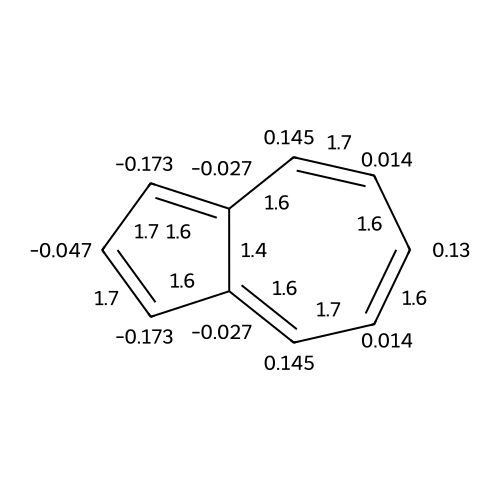

In [121]:
# draw azulene.mol with bigger size
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
img = Draw.MolToImage(azulene.mol, size=(500,500))
img

### Problem 6 SHM of three molecules with exocyclic carbon atoms

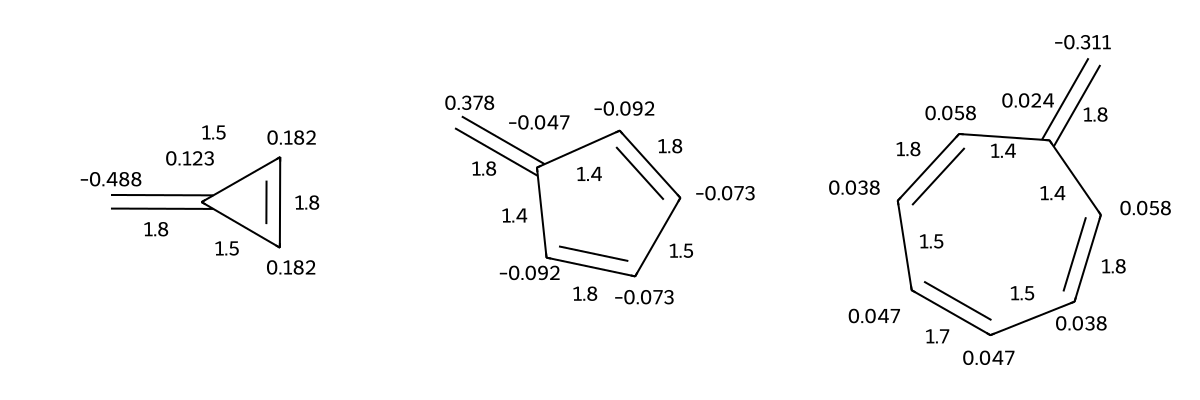

In [122]:
smiles = ['C=C1C=C1','C=C1C=CC=C1','C=C1C=CC=CC=C1']
mols = []
for smile in smiles:
    molecule = Simple_Huckel(smile)
    mols.append(molecule.mol)

# Draw the molecules in grid
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(400, 400))
img

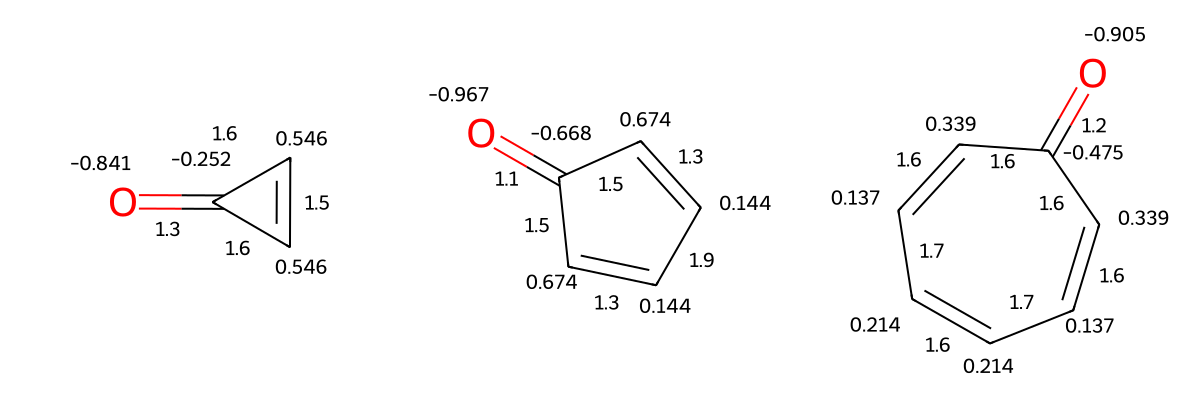

In [123]:
smiles = ['O=C1C=C1','O=C1C=CC=C1','O=C1C=CC=CC=C1']
mols = []
for smile in smiles:
    molecule = Simple_Huckel(smile)
    mols.append(molecule.mol)

# Draw the molecules in grid
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(400, 400))
img